# Characterizing the Impact of Active Queue Management (AQM) Algorithms on Data Transfers with Different Congestion Control Algorithms (CCAs)

### Topology

<img src="../AQM_CCA/files/topo.png" width="850px"><br>

# Step 1:  Configuring the environment

Before running this notebook, you will need to configure your environment using the [Configure Environment](../../../configure_and_validate.ipynb) notebook. Please stop here, open and run that notebook, then return to this notebook.

If you are using the FABRIC JupyterHub many of the environment variables will be automatically configured for you.  You will still need to set your bastion username, upload your bastion private key, and set the path to where you put your bastion private key. Your bastion username and private key should already be in your possession.  

If you are using the FABRIC API outside of the JupyterHub you will need to configure all of the environment variables. Defaults below will be correct in many situations but you will need to confirm your configuration.  If you have questions about this configuration, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

More information about accessing your experiments through the FABRIC bastion hosts can be found [here](https://learn.fabric-testbed.net/knowledge-base/logging-into-fabric-vms/).

# Step 2: Importing the FABlib library

In [13]:
import json
import traceback
from fabrictestbed_extensions.fablib.fablib import fablib

# Step 3: Creating the experiment slice

The following creates a node with basic compute and networking capabilities. You build a slice by creating a new slice and adding resources to the slice. After you build the slice, you must submit a request for the slice to be instantiated.   

### 3.1 Configuring Slice Parameters

In [14]:
from ipaddress import ip_address, IPv4Address, IPv6Address, IPv4Network, IPv6Network

# Slice 
slice_name = 'AQM_CCA'

#[site1,site2] = fablib.get_random_sites(count=2)
site1="WASH"
site2="LOSA"
print(f"Sites: {site1},{site2}")

# routeres
R1_name = "R1"
R2_name = "R2"

router_cores = 8
router_ram = 16
router_disk = 20

# Hosts
h1_name = "h1"
h2_name = "h2"

h1_subnet=IPv4Network('172.16.0.0/16')
h1_addr=IPv4Address('172.16.255.10')
R1_addr1=IPv4Address('172.16.255.254')

h2_subnet=IPv4Network('172.17.0.0/16')
h2_addr=IPv4Address('172.17.255.10')
R2_addr1=IPv4Address('172.17.255.254')

R1_subnet=IPv4Network('192.168.12.0/30')
R1_addr2=IPv4Address('192.168.12.1')

R2_subnet=IPv4Network('192.168.12.0/30')
R2_addr2=IPv4Address('192.168.12.2')

host_cores = 16
host_ram = 32
host_disk = 20

net_h1_name = 'net_h1'
net_h2_name = 'net_h2'

net_R1_R2_name = 'net_R1_R2'

# All node properties
image = 'default_ubuntu_24'

Sites: WASH,LOSA


### 3.2 Creating the Slice

This step takes around 3-4 minutes

In [15]:
try:
    #Create Slice
    slice = fablib.new_slice(name=slice_name)

    # Add router node R1
    R1 = slice.add_node(name=R1_name, site=site1,  image=image, 
                        cores=router_cores, ram=router_ram, disk=router_disk)
    R1.set_capacities(cores=router_cores, ram=router_ram, disk=router_disk)
    R1_iface_1 = R1.add_component(model='NIC_Basic', name="R1_router_nic1").get_interfaces()[0]
    R1_iface_2 = R1.add_component(model='NIC_Basic', name="R1_router_nic2").get_interfaces()[0]

     # Add router node R1
    R2 = slice.add_node(name=R2_name, site=site2,  image=image, 
                        cores=router_cores, ram=router_ram, disk=router_disk)
    R2.set_capacities(cores=router_cores, ram=router_ram, disk=router_disk)
    R2_iface_1 = R2.add_component(model='NIC_Basic', name="R2_router_nic1").get_interfaces()[0]
    R2_iface_2 = R2.add_component(model='NIC_Basic', name="R2_router_nic2").get_interfaces()[0]
    
    # Add host node h1
    h1 = slice.add_node(name=h1_name, site=site1, image=image,
                        cores=host_cores, ram=host_ram, disk=host_disk)
    h1_iface = h1.add_component(model='NIC_Basic', name="h1_nic").get_interfaces()[0]
    
    # Add host node h2
    h2 = slice.add_node(name=h2_name, site=site2, image=image,
                        cores=host_cores, ram=host_ram, disk=host_disk)
    h2_iface = h2.add_component(model='NIC_Basic', name="h2_nic").get_interfaces()[0]
    
    #Add host networks 
    host_net1 = slice.add_l2network(name=net_h1_name, interfaces=[h1_iface, R1_iface_1])
    router_net1 = slice.add_l2network(name=net_R1_R2_name, interfaces=[R1_iface_2, R2_iface_2])
    host_net2 = slice.add_l2network(name=net_h2_name, interfaces=[h2_iface, R2_iface_1])
    
    #Submit Slice Request
    slice.submit() 
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()


Retry: 8, Time: 209 sec


ID,e77cc764-1282-4ff6-a9d0-a353165ceb09
Name,AQM_CCA
Lease Expiration (UTC),2026-01-29 03:08:37 +0000
Lease Start (UTC),2026-01-28 03:08:37 +0000
Project ID,8eaa3ec2-65e7-49a3-8c09-e1761141a6ad
State,StableOK
Email,jagomez@fortlewis.edu
UserId,b884fd22-4166-4c28-bb4d-ea7b81fb5f3c


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
ad27a133-66e0-4d2f-8676-63b91c1b9519,R1,8,16,100,default_ubuntu_24,qcow2,wash-w1.fabric-testbed.net,WASH,ubuntu,2001:400:a100:3020:f816:3eff:fecc:5861,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:fecc:5861,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
5a7807b1-e2c5-4170-a5ff-96c7705227f4,R2,8,16,100,default_ubuntu_24,qcow2,losa-w3.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fe13:e257,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe13:e257,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
611074ef-9979-4533-b44b-426b8ae66f7e,h1,16,32,100,default_ubuntu_24,qcow2,wash-w1.fabric-testbed.net,WASH,ubuntu,2001:400:a100:3020:f816:3eff:fe00:5916,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:fe00:5916,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
9788126e-f358-4fc2-9e10-051e334ce462,h2,16,32,100,default_ubuntu_24,qcow2,losa-w3.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fed9:bba8,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fed9:bba8,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
3dfdee44-83a9-4dd8-a6b1-133ca874b599,net_R1_R2,L2,L2STS,None,None,None,Active,
87957e22-ca40-4275-9fc8-fa6c796593bf,net_h1,L2,L2Bridge,WASH,None,None,Active,
a21cfbfe-bc33-4043-81e4-547e9118d2d1,net_h2,L2,L2Bridge,LOSA,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
R1-R1_router_nic2-p1,p1,R1,net_R1_R2,100,config,,06:22:2B:9C:B0:45,enp7s0,enp7s0,fe80::422:2bff:fe9c:b045,6,HundredGigE0/0/0/5
R1-R1_router_nic1-p1,p1,R1,net_h1,100,config,,0A:57:F2:E2:B1:4B,enp8s0,enp8s0,fe80::857:f2ff:fee2:b14b,6,HundredGigE0/0/0/5
R2-R2_router_nic2-p1,p1,R2,net_R1_R2,100,config,,06:BA:43:20:27:43,enp6s0,enp6s0,fe80::4ba:43ff:fe20:2743,4,HundredGigE0/0/0/9
R2-R2_router_nic1-p1,p1,R2,net_h2,100,config,,06:FE:5D:78:95:3D,enp7s0,enp7s0,fe80::4fe:5dff:fe78:953d,4,HundredGigE0/0/0/9
h1-h1_nic-p1,p1,h1,net_h1,100,config,,0A:95:62:56:90:8A,enp7s0,enp7s0,fe80::895:62ff:fe56:908a,6,HundredGigE0/0/0/5
h2-h2_nic-p1,p1,h2,net_h2,100,config,,0A:03:50:C9:00:F2,enp6s0,enp6s0,fe80::803:50ff:fec9:f2,4,HundredGigE0/0/0/9



Time to print interfaces 216 seconds


### 3.3 Installing BBRv3 Kernel Module

In [16]:
h1 = slice.get_node(name="h1")     
h1.upload_file('kernel_module/linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb', 'linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb')
h1.upload_file('kernel_module/linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb', 'linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb')
h1.execute("sudo dpkg -i linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb")
h1.execute("sudo dpkg -i linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb")
h1.execute("echo 'net.ipv4.tcp_congestion_control=bbr' | sudo tee -a /etc/sysctl.conf")
h1.execute("sudo rm *.deb")
h1.execute("sudo sysctl -p")
#h1.execute("sysctl net.ipv4.tcp_congestion_control")
h1.execute("sudo reboot")

Selecting previously unselected package linux-headers-6.4.0-bbrv3.
(Reading database ... 74797 files and directories currently installed.)
Preparing to unpack linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb ...
Unpacking linux-headers-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
Setting up linux-headers-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
Selecting previously unselected package linux-image-6.4.0-bbrv3.
(Reading database ... 85045 files and directories currently installed.)
Preparing to unpack linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb ...
Unpacking linux-image-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
Setting up linux-image-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
update-initramfs: Generating /boot/initrd.img-6.4.0-bbrv3
Sourcing file `/etc/default/grub'
Sourcing file `/etc/default/grub.d/50-cloudimg-settings.cfg'
Generating grub configuration file ...
Found linux image: /boot/vmlinuz-6.8.0-63-generic
Found initrd image: /boot/initrd.img-6.8.0-63-generic
Found linux 

('', '')

### 3.4 Verifying the Kernel Module Installation

In [17]:
h1.execute("uname -a")
h1.execute("sysctl net.ipv4.tcp_available_congestion_control")

Linux h1 6.8.0-63-generic #66-Ubuntu SMP PREEMPT_DYNAMIC Fri Jun 13 20:25:30 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
net.ipv4.tcp_available_congestion_control = reno cubic bbr


('net.ipv4.tcp_available_congestion_control = reno cubic bbr\n', '')

### 3.4 Printing the Node SSH Commands

In [18]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print(f"{node.get_name()}: {node.get_ssh_command()}")
except Exception as e:
    print(f"Exception: {e}")

R1: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:fecc:5861
R2: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe13:e257
h1: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:fe00:5916
h2: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fed9:bba8


# Step 4 Configuring Nodes

### 4.1 Configuring Updates and Packages

In [19]:
config_threads = {}

In [20]:
host_config_script = "sudo apt-get update -qq && sudo apt-get -y install && sudo apt-get -y install net-tools -qq && sudo apt-get -y install iperf3 -qq  && sudo apt-get -y install mininet -qq" 

try: 
    h1 = slice.get_node(name=h1_name)
    h1.execute("sudo sed -i '1s/.*/127.0.0.1 localhost h1/' /etc/hosts")
    if type(ip_address(h1.get_management_ip())) is IPv6Address:
        h1.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")   
    h1_os_iface = h1.get_interface(network_name=net_h1_name)
    h1_os_iface.ip_addr_add(addr=h1_addr, subnet=h1_subnet)
    h1_config_thread = h1.execute_thread(host_config_script)
    config_threads[h1] = h1_config_thread
    
    h2 = slice.get_node(name=h2_name)
    h2.execute("sudo sed -i '1s/.*/127.0.0.1 localhost h2/' /etc/hosts")
    if type(ip_address(h2.get_management_ip())) is IPv6Address:
        h2.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")
    h2_os_iface = h2.get_interface(network_name=net_h2_name)
    h2_os_iface.ip_addr_add(addr=h2_addr, subnet=h2_subnet)
    h2_config_thread = h2.execute_thread(host_config_script)
    config_threads[h2] = h2_config_thread

    R1 = slice.get_node(name=R1_name)  
    R1.execute("sudo sed -i '1s/.*/127.0.0.1 localhost R1/' /etc/hosts")
    if type(ip_address(R1.get_management_ip())) is IPv6Address:
        R1.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")   
    R1_os_iface = R1.get_interface(network_name=net_h1_name)
    R1_os_iface.ip_addr_add(addr=R1_addr1, subnet=h1_subnet)
    R1_os_iface = R1.get_interface(network_name=net_R1_R2_name)
    R1_os_iface.ip_addr_add(addr=R1_addr2, subnet=R1_subnet)
    R1_config_thread = R1.execute_thread(host_config_script)
    config_threads[R1] = R1_config_thread

    R2 = slice.get_node(name=R2_name) 
    R2.execute("sudo sed -i '1s/.*/127.0.0.1 localhost R2/' /etc/hosts")
    if type(ip_address(R2.get_management_ip())) is IPv6Address:
        R2.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")   
    R2_os_iface = R2.get_interface(network_name=net_h2_name)
    R2_os_iface.ip_addr_add(addr=R2_addr1, subnet=h2_subnet)   
    R2_os_iface = R2.get_interface(network_name=net_R1_R2_name)
    R2_os_iface.ip_addr_add(addr=R2_addr2, subnet=R2_subnet)
    R2_config_thread = R2.execute_thread(host_config_script)
    config_threads[R2] = R2_config_thread

except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

### 4.2 Installing Mininet

In [24]:
h1.execute("git clone https://github.com/mininet/mininet &> /dev/null")
h1.execute("cd mininet && git checkout master &> /dev/null")
h1.execute("sudo ./util/install.sh -a &> /dev/null")

h2.execute("git clone https://github.com/mininet/mininet &> /dev/null")
h2.execute("cd mininet && git checkout master &> /dev/null")
h2.execute("sudo ./util/install.sh -a &> /dev/null")


('', '')

### 4.3 Configuring Default Routes in h1 and h2 and Static Routes in R1 and R2

In [26]:
h1.execute("sudo ifconfig enp7s0 up")
h1.execute("sudo ip route add 172.17.0.0/16 via 172.16.255.254")
h2.execute("sudo ifconfig enp6s0 up")
h2.execute("sudo ip route add 172.16.0.0/16 via 172.17.255.254")

R1.execute("sudo sysctl -w net.ipv4.conf.all.forwarding=1")
R2.execute("sudo sysctl -w net.ipv4.conf.all.forwarding=1")

R1.execute("sudo ip route add 172.17.0.0/16 via 192.168.12.2")
R2.execute("sudo ip route add 172.16.0.0/16 via 192.168.12.1")

RTNETLINK answers: File exists
RTNETLINK answers: File exists
net.ipv4.conf.all.forwarding = 1
net.ipv4.conf.all.forwarding = 1
RTNETLINK answers: File exists
RTNETLINK answers: File exists


('', 'RTNETLINK answers: File exists\n')

### 4.3 Setting TCP Send and Receive Buffer Sizes in 

In [27]:
h1.execute("sudo sysctl -w net.ipv4.tcp_wmem=\'1024 87380 200000000\'")
h1.execute("sudo sysctl -w net.ipv4.tcp_rmem=\'1024 87380 200000000\'")

h2.execute("sudo sysctl -w net.ipv4.tcp_wmem=\'1024 87380 200000000\'")
h1.execute("sudo sysctl -w net.ipv4.tcp_rmem=\'1024 87380 200000000\'")

net.ipv4.tcp_wmem = 1024 87380 200000000
net.ipv4.tcp_rmem = 1024 87380 200000000
net.ipv4.tcp_wmem = 1024 87380 200000000
net.ipv4.tcp_rmem = 1024 87380 200000000


('net.ipv4.tcp_rmem = 1024 87380 200000000\n', '')

# Step 5 Launching Mininet Topology in h1 and h2

In [29]:
#h1 = slice.get_node(name=h1_name)
#h2 = slice.get_node(name=h2_name)
num_hosts=64

h1.upload_file('scripts/topo_h1.py', 'topo_h1.py')
h2.upload_file('scripts/topo_h2.py', 'topo_h2.py')

#h1.execute('sudo mn -c &> /dev/null')
#h2.execute('sudo mn -c &> /dev/null')

h1.execute('mkdir results')
h2.execute('mkdir results')

#h1.execute(f'sudo python3 topo_h1.py {num_hosts} &')
#h2.execute(f'sudo python3 topo_h2.py {num_hosts} &')

mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘results’: File exists


('', 'mkdir: cannot create directory ‘results’: File exists\n')

### !!!Run the scripts manually in the VMS

In [30]:
print(f"Run the following command on h1: sudo python3 topo_h1.py {num_hosts}")
print(f"Run the following command on h2: sudo python3 topo_h2.py {num_hosts}")

Run the following command on h1: sudo python3 topo_h1.py 64
Run the following command on h2: sudo python3 topo_h2.py 64


## 5.1 Adding the VM's Port to router R1

In [32]:
h1.execute('sudo ovs-vsctl add-port s_agg1 enp7s0')
h2.execute('sudo ovs-vsctl add-port s_agg2 enp6s0')

ovs-vsctl: cannot create a port named enp7s0 because a port named enp7s0 already exists on bridge s_agg1


('', '')

## 5.2 Configure static Routes in the Mininet hosts

In [33]:
for i in range(1, num_hosts + 1):
    print(f"Setting default route on host hs{i} and hr{i}")
    h1.execute_thread(f"mininet/util/m hs{i} route add default gw 172.16.255.254 &> /dev/null")
    h2.execute_thread(f"mininet/util/m hr{i} route add default gw 172.17.255.254 &> /dev/null")
print(f"Default routes configured in sender hosts (hs) and receiver hosts (hr)")

Setting default route on host hs1 and hr1
Setting default route on host hs2 and hr2
Setting default route on host hs3 and hr3
Setting default route on host hs4 and hr4
Setting default route on host hs5 and hr5
Setting default route on host hs6 and hr6
Setting default route on host hs7 and hr7
Setting default route on host hs8 and hr8
Setting default route on host hs9 and hr9
Setting default route on host hs10 and hr10
Setting default route on host hs11 and hr11
Setting default route on host hs12 and hr12
Setting default route on host hs13 and hr13
Setting default route on host hs14 and hr14
Setting default route on host hs15 and hr15
Setting default route on host hs16 and hr16
Setting default route on host hs17 and hr17
Setting default route on host hs18 and hr18
Setting default route on host hs19 and hr19
Setting default route on host hs20 and hr20
Setting default route on host hs21 and hr21
Setting default route on host hs22 and hr22
Setting default route on host hs23 and hr23
Settin

## 5.3 Populating the ARP tables in the Mininet Hosts

In [35]:
for i in range(1, num_hosts + 1):
    h1.execute_thread(f"mininet/util/m hs{i} ping 172.17.0.{i} -c 1")
    h2.execute_thread(f"mininet/util/m hr{i} ping 172.16.0.{i} -c 1")

## 5.4 Starting the iPerf3 Servers in h2

In [36]:
for i in range(1, num_hosts + 1):
    print(f"Starting iperf3 server on host hr{i}")
    h2.execute_thread(f"mininet/util/m hr{i} iperf3 -s")

Starting iperf3 server on host hr1
Starting iperf3 server on host hr2
Starting iperf3 server on host hr3
Starting iperf3 server on host hr4
Starting iperf3 server on host hr5
Starting iperf3 server on host hr6
Starting iperf3 server on host hr7
Starting iperf3 server on host hr8
Starting iperf3 server on host hr9
Starting iperf3 server on host hr10
Starting iperf3 server on host hr11
Starting iperf3 server on host hr12
Starting iperf3 server on host hr13
Starting iperf3 server on host hr14
Starting iperf3 server on host hr15
Starting iperf3 server on host hr16
Starting iperf3 server on host hr17
Starting iperf3 server on host hr18
Starting iperf3 server on host hr19
Starting iperf3 server on host hr20
Starting iperf3 server on host hr21
Starting iperf3 server on host hr22
Starting iperf3 server on host hr23
Starting iperf3 server on host hr24
Starting iperf3 server on host hr25
Starting iperf3 server on host hr26
Starting iperf3 server on host hr27
Starting iperf3 server on host hr28
S

## 6.2 Running the Test

### 6.2.1 Starting the iPerf3 clients

In [22]:
for i in range(1, num_hosts + 1):
    h1.execute_thread(f"mininet/util/m hs{i} iperf3 -c 172.17.0.{i} -J > results/hs{i}_out.json &")

### 6.2.2 Getting the JSON Files

In [23]:
for i in range(1, num_hosts + 1):
    h1.download_file(f"results/hs{i}_out.json",f"results/hs{i}_out.json")

## 6.3 Plotting the Results

### 6.3.1 Plot as a Function of Time

/tmp/ipykernel_160/4248212304.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc="lower right")


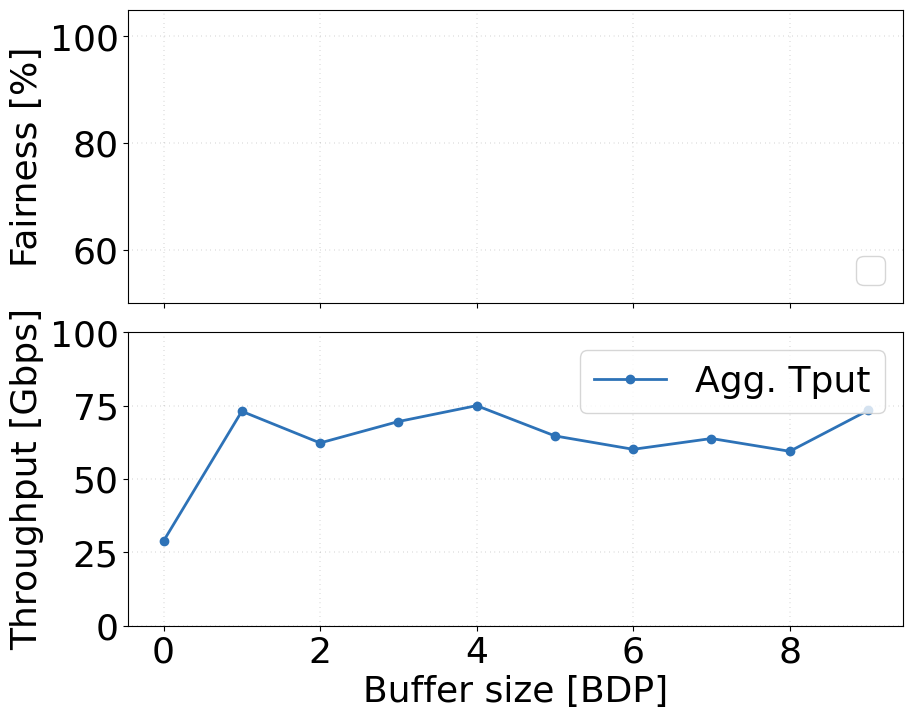

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib

# Load throughput data from JSON
def extract_iperf_timming(filename):   
    with open(filename) as f:
        data = json.load(f)
    dur = int(data['end']['sum_sent']['end'])
    result = []
    for i in range(0, dur):
       result.append(float(data['intervals'][i]['sum']['bits_per_second']) / 1e9)
    
    return result

# Plot setup for fair and clean visuals
def setup_plot(font_size=26):
    font = {'family': 'normal', 'weight': 'normal', 'size': font_size}
    matplotlib.rc('font', **font)
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.1)
    for ax in axes:
        ax.grid(True, which="both", lw=0.3, linestyle=(0, (1, 10)), color='black')
    return fig, axes

# Calculate fairness based on throughput
def calculate_fairness(cubic, bbr3):
    return [
        100 * (c + b) ** 2 / (2 * (c ** 2 + b ** 2))
        for c, b in zip(cubic, bbr3)
    ]

# Main plotting function for experiment results
def plot_results(throughput, filename="output.pdf"):
    #fairness = calculate_fairness(cubic, bbr3)
    fig, axes = setup_plot()
    t = list(range(0, len(throughput)))
    # Plotting fairness and throughput
   
    axes[1].plot(t, throughput, '#2D72B7', linewidth=2, label='Agg. Tput', marker='o')

    # Set labels and legends
    axes[0].set_ylabel('Fairness [%]')
    axes[1].set_ylabel('Throughput [Gbps]')
    axes[1].set_xlabel('Buffer size [BDP]')
    axes[0].legend(loc="lower right")
    axes[1].legend(loc="upper right", ncol=2)
    axes[0].set_ylim([50, 105])
    axes[1].set_ylim([0, 100])

    fig.savefig(filename, bbox_inches='tight')

def main():
    th = []
    # Extract the Throughput of each flow
    for i in range(1, num_hosts + 1):
        th.append(extract_iperf_timming(f"results/hs{i}_out.json"))

    # 
    agg_th = [sum(column) for column in zip(*th)]
    plot_results(agg_th, filename="output.pdf")
        
        
    #setup_plot(font_size=26)

            
if __name__ == '__main__':
    main()


# Step 5 Misc Scripts

### 5.1 Listing Available Sites

In [ ]:
try:
    print(f"{fablib.list_sites()}")
except Exception as e:
    print(f"Exception: {e}")

### 5.2 Printing Slice Attributes

In [25]:
try:
    slice = fablib.get_slice(name=slice_name)
    print(f"{slice}")
except Exception as e:
    print(f"Exception: {e}")

Exception: Unable to find slice "bbr3_test" for this project. Check slice name spelling and project id.


### 5.3 Printing the Node Attributes

In [6]:
try:
    slice = fablib.get_slice(name=slice_name)

    print(f"{slice.list_nodes()}")
except Exception as e:
    print(f"Exception: {e}")

Exception: Unable to find slice "bbr3_test" for this project. Check slice name spelling and project id.


### 5.4 Printing the Node Details

In [45]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print(f"{node}")
except Exception as e:
    print(f"Exception: {e}")

-----------------  --------------------------------------------------------------------------------------------------------------------------------------------
ID                 f3e35fad-94ea-4070-a58c-f2579d54bf7d
Name               s1
Cores              2
RAM                8
Disk               100
Image              default_ubuntu_22
Image Type         qcow2
Host               newy-w2.fabric-testbed.net
Site               NEWY
Management IP      2001:400:a100:3040:f816:3eff:fe2e:e3a6
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3040:f816:3eff:fe2e:e3a6
-----------------  --------------------------------------------------------------------------------------------------------------------------------------------
-----------------  --------------------------------------------------------------------------------------------------------------------------------

#### 5.5 Printing Interfaces

In [46]:
try:
    slice = fablib.get_slice(name=slice_name)
    
    print(f"{slice.list_interfaces()}")
except Exception as e:
    print(f"Exception: {e}")

Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
s1-s1_switch_nic1-p1,p1,s1,net_h1,100,config,,0E:62:1A:D6:09:B9,enp7s0,enp7s0,172.16.0.1,4,HundredGigE0/0/0/7
s1-s1_switch_nic2-p1,p1,s1,net_s1_s2,100,config,,12:BA:40:30:C3:36,enp8s0,enp8s0,192.168.12.1,4,HundredGigE0/0/0/7
s2-s2_switch_nic2-p1,p1,s2,net_s1_s2,100,config,,06:D4:16:2C:10:10,enp8s0,enp8s0,192.168.12.2,6,HundredGigE0/0/0/5
s2-s2_switch_nic1-p1,p1,s2,net_h2,100,config,,06:C9:EE:46:AB:31,enp7s0,enp7s0,172.17.0.1,6,HundredGigE0/0/0/5
h1-h1_nic-p1,p1,h1,net_h1,100,config,,16:24:75:91:49:87,enp7s0,enp7s0,172.16.0.10,4,HundredGigE0/0/0/7
h2-h2_nic-p1,p1,h2,net_h2,100,config,,0E:1E:17:82:0A:70,enp7s0,enp7s0,172.17.0.10,6,HundredGigE0/0/0/5


### 5.6 Deleting a Slice

In [12]:
slice.delete()